In [1]:
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter


EPSILON = 1e-10
RETURN_SCALE = 100

# if __name__ == "__main__":

start_time = '1577836800'
end_time = '1578441600'

# df_ = get_prices(
#     'btc', 'usdt',
#     datetime(2020, 1, 1),
#     duration=timedelta(days=7),
#     proxy_port='13070',
#     verbose=2)

df_ = pd.read_csv('data/BTCUSDT[' + start_time + '000_' + end_time + '000].csv')
df_.drop(['Unnamed: 0'], inplace=True, axis=1)
df_['Time'] = pd.to_datetime(df_['Time'])
df_.set_index('Time', inplace=True, drop=True)

times_index = pd.date_range(start=pd.to_datetime(start_time, unit='s'),
                            end=pd.to_datetime(end_time, unit='s'),
                            periods=(int(end_time) - int(start_time) + 1) / 60 + 1)

df = pd.DataFrame(None, columns=df_.columns, index=times_index[:-1])

selected_indices = list(set(df_.index).intersection(set(times_index)))
df.loc[selected_indices, df_.columns] = df_.loc[selected_indices].copy()

In [2]:
df['Feature 1'] = df['Taker Buy Volume'] / (df['Volume'] + EPSILON) * 100

df['Feature 2'] = (df['Volume'] + EPSILON).pct_change() * 100

df['Feature 3'] = df['Taker Buy Value'] / df['Taker Buy Volume'] - \
                  ((df['Value'] - df['Taker Buy Value']) / (df['Volume'] - df['Taker Buy Volume'] + EPSILON))

def historical_high_to_low_ratio(window):
    tmp = df['High'].rolling(window).max()
    return (tmp-df['Close']) / (tmp-df['Low'].rolling(window).min() + EPSILON) * 100

for i, t in enumerate([1, 6, 24]):
    window = int(timedelta(hours=t) / timedelta(minutes=1))
    df[f'Feature {4+i}'] = historical_high_to_low_ratio(window)

# period = 10
# for i in range(period):
#     df[f'Return {i+1} min'] = (df['Close'].shift(-i-1) / df['Close'] - 1) * 100
df

,Market,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6
2020-01-01 00:00:00,BTCUSDT,7195.24,7196.25,7183.14,7186.68,51.642812,371233.518355,493,19.59823,140888.414283,37.94958,NaN,0.563703,NaN,NaN,NaN
2020-01-01 00:01:00,BTCUSDT,7187.67,7188.06,7182.2,7184.03,7.248148,52080.127788,135,2.031772,14599.211924,28.031602,-85.964846,0.217325,NaN,NaN,NaN
2020-01-01 00:02:00,BTCUSDT,7184.41,7184.71,7180.26,7182.43,11.681677,83903.741635,202,5.479244,39357.081776,46.904601,61.167749,0.813428,NaN,NaN,NaN
2020-01-01 00:03:00,BTCUSDT,7183.83,7188.94,7182.49,7185.94,10.025391,72033.226649,136,3.294966,23680.571924,32.866209,-14.178495,2.703759,NaN,NaN,NaN
2020-01-01 00:04:00,BTCUSDT,7185.54,7185.54,7178.64,7179.78,14.911105,107066.521825,161,2.369033,17012.015138,15.887709,48.733401,0.8017,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:55:00,BTCUSDT,8163.09,8180.78,8162.58,8174.52,56.340474,460369.470177,664,34.532792,282162.676837,61.293045,12.595400,-0.881976,17.734517,11.495528,6.851664
2020-01-07 23:56:00,BTCUSDT,8174.52,8176.52,8162.58,8168.48,46.824082,382487.910867,442,18.526946,151332.558308,39.567131,-16.890863,-0.619447,20.964809,13.589406,8.099676
2020-01-07 23:57:00,BTCUSDT,8167.76,8170.67,8157.5,8158.96,42.212437,344654.966852,403,19.19538,156750.172947,45.473281,-9.848874,2.317097,26.056263,16.88969,10.06674
2020-01-07 23:58:00,BTCUSDT,8158.73,8162.0,8153.77,8161.5,103.923,847779.49378,538,56.297305,459258.542236,54.172132,146.190477,-0.065362,24.697829,16.009152,9.541914


In [3]:
# returns = df['Close'].pct_change() * 100 * RETURN_SCALE
# returns[0] = (df.iloc[0]['Close'] / df.iloc[0]['Open'] - 1) * 100 * RETURN_SCALE
# df['Return'] = returns
# df

In [94]:
# df['Weighted Price Average'] = df['Value'] / df['Volume']
# m = 100
# plt.figure(figsize=(20, 10))
# plt.xticks(rotation=90)
# plt.plot(
#     df.iloc[0:m].index,
#     df['Weighted Price Average'][0:m],
#     color='black')
# x_limits = plt.xlim()
# x_width = x_limits[1] - x_limits[0]
# plt.bar(
#     x=df.iloc[0:m].index,
#     height=df['Close'].shift(1)[0:m]-df['Weighted Price Average'][0:m],
#     width=0.1*(x_width / m),
#     bottom=df['Weighted Price Average'][0:m],
#     color='red')
# plt.scatter(
#     df.iloc[0:m].index,
#     df['Close'].shift(1)[0:m],
#     color='red'
# )
# plt.show()

In [5]:
real_return = df['Weighted Price Average'].pct_change() * 100 * RETURN_SCALE
real_return[0] = (df.iloc[0]['Weighted Price Average'] / df.iloc[0]['Open'] - 1) * 100 * RETURN_SCALE
df['Real Return'] = real_return
df

,Market,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Weighted Price Average,Real Return
2020-01-01 00:00:00,BTCUSDT,7195.24,7196.25,7183.14,7186.68,51.642812,371233.518355,493,19.59823,140888.414283,37.94958,NaN,0.563703,NaN,NaN,NaN,7188.483818,-9.389794
2020-01-01 00:01:00,BTCUSDT,7187.67,7188.06,7182.2,7184.03,7.248148,52080.127788,135,2.031772,14599.211924,28.031602,-85.964846,0.217325,NaN,NaN,NaN,7185.301375,-4.427141
2020-01-01 00:02:00,BTCUSDT,7184.41,7184.71,7180.26,7182.43,11.681677,83903.741635,202,5.479244,39357.081776,46.904601,61.167749,0.813428,NaN,NaN,NaN,7182.508268,-3.887251
2020-01-01 00:03:00,BTCUSDT,7183.83,7188.94,7182.49,7185.94,10.025391,72033.226649,136,3.294966,23680.571924,32.866209,-14.178495,2.703759,NaN,NaN,NaN,7185.079031,3.579199
2020-01-01 00:04:00,BTCUSDT,7185.54,7185.54,7178.64,7179.78,14.911105,107066.521825,161,2.369033,17012.015138,15.887709,48.733401,0.8017,NaN,NaN,NaN,7180.321098,-6.621963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:55:00,BTCUSDT,8163.09,8180.78,8162.58,8174.52,56.340474,460369.470177,664,34.532792,282162.676837,61.293045,12.595400,-0.881976,17.734517,11.495528,6.851664,8171.203355,9.497380
2020-01-07 23:56:00,BTCUSDT,8174.52,8176.52,8162.58,8168.48,46.824082,382487.910867,442,18.526946,151332.558308,39.567131,-16.890863,-0.619447,20.964809,13.589406,8.099676,8168.615262,-3.167334
2020-01-07 23:57:00,BTCUSDT,8167.76,8170.67,8157.5,8158.96,42.212437,344654.966852,403,19.19538,156750.172947,45.473281,-9.848874,2.317097,26.056263,16.88969,10.06674,8164.773023,-4.703660
2020-01-07 23:58:00,BTCUSDT,8158.73,8162.0,8153.77,8161.5,103.923,847779.49378,538,56.297305,459258.542236,54.172132,146.190477,-0.065362,24.697829,16.009152,9.541914,8157.765786,-8.582280


In [122]:
from scipy.stats import pearsonr
x = df['Real Return']
tmp = []
for i in range(20):
    y = x.shift(i+1).copy()
    intersection = sorted(list(set(x.dropna().index).intersection(set(y.dropna().index))))
    tmp.append(pearsonr(x.loc[intersection], y.loc[intersection]))
# tmp = list(reversed(tmp))
tmp = np.array(tmp)

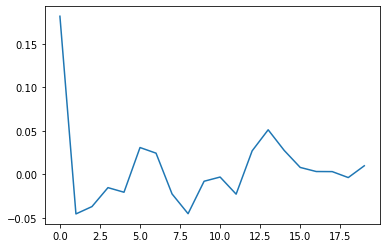

In [123]:
%matplotlib inline
plt.plot(tmp[:, 0])
plt.show()

In [ ]:
k = 120
m = 15
r = 6

df['Prediction'] = None
df['Measurement'] = None

alpha = 1.1
W = np.diag(alpha ** np.arange(k) / np.sum(alpha ** np.arange(k)))
for n in np.arange(1440*5) + 2880:
    A = np.zeros([k, m+r])
    A[:, m:m+r] = df.iloc[(n-2)-(k-1):(n-2)+1][[f'Feature {i+1}' for i in range(r)]].to_numpy()
    for i in range(m):
        A[:, i] = df.iloc[(n-2)-(k-1)-i:(n-2)-i+1]['Real Return']
    b = df.iloc[(n-1)-(k-1):(n-1)+1]['Real Return'].values
    theta, _, _, _ = np.linalg.lstsq(np.dot(W, A), np.dot(W, b), rcond=-1)

    prediction = np.dot(theta, np.concatenate([df.iloc[n-1:n-m-1:-1]['Real Return'].values,
                                               df.iloc[n-1][[f'Feature {i+1}' for i in range(r)]].values]).ravel())
    df.loc[df.index[n], 'Prediction'] = (1 + prediction / (100 * RETURN_SCALE)) * df.iloc[n-1]['Weighted Price Average']
    df.loc[df.index[n], 'Measurement'] = df.iloc[n]['Open']

df

In [254]:
indices = (df['Measurement'] - df['Weighted Price Average']).dropna().index

print(
    (df.loc[indices, 'Measurement'] - df.loc[indices, 'Weighted Price Average']).var(),
    (df.loc[indices, 'Prediction'] - df.loc[indices, 'Weighted Price Average']).var(),
    (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).var()
)

df.loc[indices]

15.697884412174904 1420.9905366592998 27.019580662749565


,Market,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,...,Feature 6,Weighted Price Average,Real Return,Prediction,Measurement,Measurement Residual,Prediction Residual,Measurement Residual Weighted Variance,Prediction Residual Weighted Variance,Estimate
2020-01-03 00:00:00,BTCUSDT,6965.49,6965.71,6960.51,6961.42,11.291589,78627.43186,162,4.579532,31891.679144,...,87.253267,6963.362894,0.615193,6964.142706,6965.49,2.127106,-0.01963,NaN,NaN,NaN
2020-01-03 00:01:00,BTCUSDT,6961.57,6963.2,6958.3,6961.06,16.231409,112976.459871,204,12.179533,84774.931854,...,87.378371,6960.360611,-4.311542,6960.664845,6961.57,1.209389,2.931442,NaN,NaN,NaN
2020-01-03 00:02:00,BTCUSDT,6960.61,6961.84,6955.0,6956.32,10.534723,73303.537454,177,2.131688,14834.02476,...,89.025577,6958.278585,-2.991262,6964.709211,6960.61,2.331415,3.401948,NaN,NaN,NaN
2020-01-03 00:03:00,BTCUSDT,6956.31,6957.63,6952.86,6957.33,17.161349,119351.82475,269,3.594401,24999.993693,...,88.67459,6954.687813,-5.160432,6954.878646,6956.31,1.622187,3.082337,NaN,NaN,NaN
2020-01-03 00:04:00,BTCUSDT,6956.38,6957.61,6952.77,6956.03,19.905717,138436.281323,224,7.684713,53448.918688,...,89.126355,6954.599089,-0.127574,6952.931551,6956.38,1.780911,-1.345368,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:55:00,BTCUSDT,8163.09,8180.78,8162.58,8174.52,56.340474,460369.470177,664,34.532792,282162.676837,...,6.851664,8171.203355,9.497380,8110.06169,8163.09,-8.113355,-44.363042,78.424532,643.420328,8159.151668
2020-01-07 23:56:00,BTCUSDT,8174.52,8176.52,8162.58,8168.48,46.824082,382487.910867,442,18.526946,151332.558308,...,8.099676,8168.615262,-3.167334,8098.146461,8174.52,5.904738,-64.496618,80.724158,975.607671,8169.139976
2020-01-07 23:57:00,BTCUSDT,8167.76,8170.67,8157.5,8158.96,42.212437,344654.966852,403,19.19538,156750.172947,...,10.06674,8164.773023,-4.703660,8198.16234,8167.76,2.986977,31.837836,80.467589,1070.186901,8169.777599
2020-01-07 23:58:00,BTCUSDT,8158.73,8162.0,8153.77,8161.5,103.923,847779.49378,538,56.297305,459258.542236,...,9.541914,8157.765786,-8.582280,8097.593886,8158.73,0.964214,-24.214586,80.678726,1109.275145,8157.02288


In [255]:
df['Measurement Residual'] = df['Measurement'] - df['Weighted Price Average']
df['Prediction Residual'] = df['Prediction'] - df['Weighted Price Average']
df['Measurement Residual Weighted Variance'] = df['Measurement Residual'].rolling(26).var()
df['Prediction Residual Weighted Variance'] = df['Prediction Residual'].rolling(13).var()
df['Estimate'] = (df['Measurement Residual Weighted Variance'] * df['Prediction'] + df['Prediction Residual Weighted Variance'] * df['Measurement']) / (df['Measurement Residual Weighted Variance'] + df['Prediction Residual Weighted Variance'])
df.loc[indices]

,Market,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,...,Feature 6,Weighted Price Average,Real Return,Prediction,Measurement,Measurement Residual,Prediction Residual,Measurement Residual Weighted Variance,Prediction Residual Weighted Variance,Estimate
2020-01-03 00:00:00,BTCUSDT,6965.49,6965.71,6960.51,6961.42,11.291589,78627.43186,162,4.579532,31891.679144,...,87.253267,6963.362894,0.615193,6964.142706,6965.49,2.127106,0.779812,NaN,NaN,NaN
2020-01-03 00:01:00,BTCUSDT,6961.57,6963.2,6958.3,6961.06,16.231409,112976.459871,204,12.179533,84774.931854,...,87.378371,6960.360611,-4.311542,6960.664845,6961.57,1.209389,0.304233,NaN,NaN,NaN
2020-01-03 00:02:00,BTCUSDT,6960.61,6961.84,6955.0,6956.32,10.534723,73303.537454,177,2.131688,14834.02476,...,89.025577,6958.278585,-2.991262,6964.709211,6960.61,2.331415,6.430626,NaN,NaN,NaN
2020-01-03 00:03:00,BTCUSDT,6956.31,6957.63,6952.86,6957.33,17.161349,119351.82475,269,3.594401,24999.993693,...,88.67459,6954.687813,-5.160432,6954.878646,6956.31,1.622187,0.190833,NaN,NaN,NaN
2020-01-03 00:04:00,BTCUSDT,6956.38,6957.61,6952.77,6956.03,19.905717,138436.281323,224,7.684713,53448.918688,...,89.126355,6954.599089,-0.127574,6952.931551,6956.38,1.780911,-1.667538,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 23:55:00,BTCUSDT,8163.09,8180.78,8162.58,8174.52,56.340474,460369.470177,664,34.532792,282162.676837,...,6.851664,8171.203355,9.497380,8110.06169,8163.09,-8.113355,-61.141665,78.424532,1013.288484,8159.280647
2020-01-07 23:56:00,BTCUSDT,8174.52,8176.52,8162.58,8168.48,46.824082,382487.910867,442,18.526946,151332.558308,...,8.099676,8168.615262,-3.167334,8098.146461,8174.52,5.904738,-70.468802,80.724158,1348.366274,8170.205935
2020-01-07 23:57:00,BTCUSDT,8167.76,8170.67,8157.5,8158.96,42.212437,344654.966852,403,19.19538,156750.172947,...,10.06674,8164.773023,-4.703660,8198.16234,8167.76,2.986977,33.389317,80.467589,1485.202111,8169.322528
2020-01-07 23:58:00,BTCUSDT,8158.73,8162.0,8153.77,8161.5,103.923,847779.49378,538,56.297305,459258.542236,...,9.541914,8157.765786,-8.582280,8097.593886,8158.73,0.964214,-60.1719,80.678726,1688.479121,8155.942016


In [256]:
%matplotlib notebook

plt.xticks(rotation=90)
plt.plot(
    indices,
    df.loc[indices, 'Weighted Price Average'],
    color='black'
)

# plot measurement errors
plt.vlines(
    x=indices,
    ymin=df.loc[indices, 'Weighted Price Average'],
    ymax=df.loc[indices, 'Measurement'],
    color='red'
)
plt.scatter(
    indices,
    df.loc[indices, 'Measurement'],
    color='red'
)

# plot model approximation errors
plt.vlines(
    x=indices,
    ymin=df.loc[indices, 'Weighted Price Average'],
    ymax=df.loc[indices, 'Prediction'],
    color='blue'
)
plt.scatter(
    indices,
    df.loc[indices, 'Prediction'],
    color='blue'
)

# plot model approximation errors
plt.vlines(
    x=indices,
    ymin=df.loc[indices, 'Weighted Price Average'],
    ymax=df.loc[indices, 'Estimate'],
    color='green'
)
plt.scatter(
    indices,
    df.loc[indices, 'Estimate'],
    color='green',
    marker='x'
)
plt.show()

<IPython.core.display.Javascript object>

/home/m.ghodrati@rasad.local/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/m.ghodrati@rasad.local/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


In [257]:
print(
    "Measurement:\t",
    (df.loc[indices, 'Measurement'] - df.loc[indices, 'Weighted Price Average']).std(),
    "\n Prediction:\t",
    (df.loc[indices, 'Prediction'] - df.loc[indices, 'Weighted Price Average']).std(),
    "\n   Estimate:\t",
    (df.loc[indices, 'Estimate'] - df.loc[indices, 'Weighted Price Average']).std(),
    "R_square:",
    1 - np.sqrt((df.loc[indices, 'Estimate'] - df.loc[indices, 'Weighted Price Average']).var() /
        (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).var()),
    "\n   Base std:\t",
    (df.shift(1).loc[indices, 'Weighted Price Average'] - df.loc[indices, 'Weighted Price Average']).std()
)

Measurement:	 3.9620555791375396 
 Prediction:	 37.69602812842886 
   Estimate:	 4.072499219785586 R_square: 0.2165311978397625 
   Base std:	 5.198036231380998


In [68]:
def get_linear_dynamics_with_lsm(df, n, ls_frame_size, dynamics_memory):
    m = max(dynamics_memory-1, n-ls_frame_size)
    if n <= dynamics_memory:
        return None
    A = np.zeros([n-m, dynamics_memory])
    for i in range(dynamics_memory):
        A[:, i] = z[m-i:n-i]
    b = np.array(z[m+1:n+1], dtype='float64')
    theta, _, _, _ = np.linalg.lstsq(A, b, rcond=-1)
    F = np.zeros([dynamics_memory, dynamics_memory])
    F[-1, :] = np.array(list(reversed(theta)))
    F[0:dynamics_memory-1, 1:] = np.eye(dynamics_memory-1)
    return F

z = df['Return'].values
z_hat = df['Return'].values

n_train = 240  # 4 hours
memory = 20    # 20 minutes
n_test = 10    # 10 minutes
for n in range(n_train, len(z), n_test):
    F = get_linear_dynamics_with_lsm(z, n, n_train, memory)
    kf = KalmanFilter(transition_matrices=F)
    measurements = np.asarray([list(z[n-memory+i:n+i]) for i in range(n_test)])
    print(measurements.shape, kf.transition_matrices.shape)
    kf = kf.em(measurements, n_iter=5)
    (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)

    print(filtered_state_means)
    z_hat[n:n+n_test] = filtered_state_means[:, -1]
    # errors['filtered'][n] = 0

z_hat

(1, 4) (4, 4)
[[-0.02957994  0.01394971 -0.0416536   0.00888947]
 [ 0.01574652 -0.04165376  0.0088895  -0.00441657]
 [-0.05292536  0.00889026 -0.00450278  0.00277905]
 [ 0.0129032  -0.00464327  0.00286794 -0.00361711]]


ValueError: could not broadcast input array from shape (4,) into shape (1,)

In [58]:
type(np.squeeze(np.asarray(F)))
# type(F)
F = np.random.randn(10, 10)
np.dot(F, np.asarray(list(range(10))))

array([-51.53871788,  -9.48461319,  -7.86086927,   6.62900904,
         1.31533311,  -2.09186571,  -3.8094132 , -34.04218302,
       -21.89790975, -14.92398836])

In [36]:

import numpy as np
kf = KalmanFilter(transition_matrices = [[1, 1], [0, 1]], observation_matrices = np.eye(2))
measurements = np.asarray([[1,0], [0,0], [0,1]])  # 3 observations
kf = kf.em(measurements, n_iter=5)
kf.transition_matrices.shape
# (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)

(2, 2)

In [32]:
filtered_state_means

array([[ 0.738534  , -0.08539035],
       [ 0.24035819,  0.02275462],
       [ 0.02956649,  0.8233288 ]])

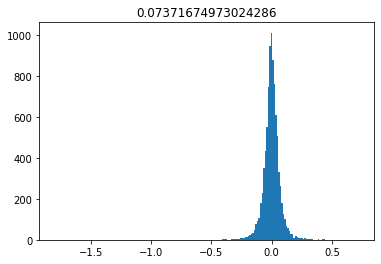

In [62]:
plt.hist(errors[frame_size:len(z)], bins=200)
plt.title(errors[frame_size:len(z)].std())
plt.show()

In [60]:
x = np.array([-2.1, -1,  4.3])

y = np.array([0,  1,  0.2])

X = np.stack((x, x+y, y), axis=0)

np.cov(X)

array([[11.71, 11.4 , -0.31],
       [11.4 , 11.37, -0.03],
       [-0.31, -0.03,  0.28]])

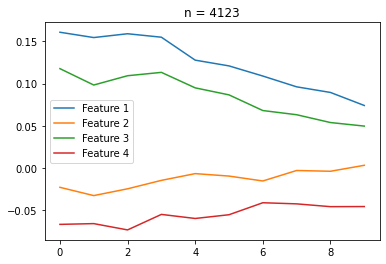

In [4]:
from scipy.stats import pearsonr
result = []
data = df.dropna().copy()
data = data[(data['Feature 2'] >= 3) & (data['No. Trades'] > 100)]
for i in range(period):
    for j in range(4):
        result.append(pearsonr(data[f'Return {i+1} min'], data[f'Feature {j+1}']))
result = np.array(result)
result = result.reshape(-1, 8)
for j in range(4):
    plt.plot(result[:, 2*j], label=f'Feature {j+1}')
plt.legend()
plt.title(f'n = {len(data)}')
plt.show()

In [6]:
# t_train_start = datetime(2018, 1, 1, 1)
# t_train_duration = timedelta(hours=6)
# x_train = x.loc[t_train_start:t_train_start+t_train_duration-timedelta(minutes=1)]
# A =